In [2]:
import pandas as pd
import numpy as np

# 전처리 완료 데이터 불러오기
data_a = pd.read_csv("./datasets/data_after/전처리_최종_V3_loglag.csv", encoding="CP949")
data_a = data_a.set_index('기준월')

### 기초통계량 분석

In [3]:
# 정보
data_a.info()

<class 'pandas.core.frame.DataFrame'>
Index: 214 entries, 2004-07 to 2022-06
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   만기전상환율       214 non-null    float64
 1   가중평균발행금리     214 non-null    float64
 2   주택종합 매매가격지수  214 non-null    float64
 3   주택종합 전세가격지수  214 non-null    float64
 4   소비자물가지수      214 non-null    float64
 5   15-64 실업자 수  214 non-null    float64
 6   코스피 월별 종가    214 non-null    float64
 7   예금은행 대출금리    214 non-null    float64
 8   평균 LTV       214 non-null    float64
 9   평균 DTI       214 non-null    float64
 10  CD금리         214 non-null    float64
 11  인플레이션율       214 non-null    float64
 12  미국 실효금리      214 non-null    float64
dtypes: float64(13)
memory usage: 23.4+ KB


In [4]:
# 결측치 확인
data_a.isna().sum()

만기전상환율         0
가중평균발행금리       0
주택종합 매매가격지수    0
주택종합 전세가격지수    0
소비자물가지수        0
15-64 실업자 수    0
코스피 월별 종가      0
예금은행 대출금리      0
평균 LTV         0
평균 DTI         0
CD금리           0
인플레이션율         0
미국 실효금리        0
dtype: int64

In [5]:
# 기초 통계 조회
data_a.describe()

,만기전상환율,가중평균발행금리,주택종합 매매가격지수,주택종합 전세가격지수,소비자물가지수,15-64 실업자 수,코스피 월별 종가,예금은행 대출금리,평균 LTV,평균 DTI,CD금리,인플레이션율,미국 실효금리
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,2.125790,3.773027,70.835033,72.083953,4.496383,6.771244,7.513644,1.415123,59.874064,32.485376,0.866499,0.189481,-0.777562
std,1.295680,0.954468,11.059051,15.072584,0.106253,0.131812,0.288032,0.314779,1.158292,1.313916,0.542269,0.352278,1.532233
min,0.037500,2.447768,51.567000,49.086000,4.278318,6.527958,6.600333,0.871293,57.812187,29.270000,-0.462035,-0.744313,-2.995732
25%,1.236738,2.869294,63.628000,56.417250,4.414212,6.677712,7.395603,1.152934,59.055704,31.498212,0.490109,-0.067598,-2.207275
50%,1.748847,3.411875,70.716000,73.672000,4.531157,6.748760,7.583812,1.360977,59.968668,32.773154,0.974560,0.179601,-1.267889
75%,2.753005,4.801858,77.204250,85.564000,4.584640,6.856462,7.652164,1.695616,60.562161,33.592059,1.264127,0.404551,0.696888
max,9.681872,5.236765,100.768000,100.814000,4.678049,7.078342,8.100671,2.025513,62.019524,34.461733,1.796747,1.188525,1.660131


In [6]:
# 아주 간단하게 상관관계 분석
data_a.corr()

,만기전상환율,가중평균발행금리,주택종합 매매가격지수,주택종합 전세가격지수,소비자물가지수,15-64 실업자 수,코스피 월별 종가,예금은행 대출금리,평균 LTV,평균 DTI,CD금리,인플레이션율,미국 실효금리
만기전상환율,1.000000,-0.212187,0.071402,0.212557,0.265383,0.091006,0.221319,-0.333767,-0.471657,0.328658,-0.120067,-0.206792,-0.482538
가중평균발행금리,-0.212187,1.000000,-0.859188,-0.960978,-0.905004,-0.408910,-0.737516,0.945414,0.087004,0.622796,0.877357,0.126407,0.330174
주택종합 매매가격지수,0.071402,-0.859188,1.000000,0.950540,0.935405,0.224822,0.863680,-0.750758,-0.152847,-0.665767,-0.807315,0.008612,-0.440674
주택종합 전세가격지수,0.212557,-0.960978,0.950540,1.000000,0.966397,0.332931,0.842150,-0.882945,-0.166292,-0.623201,-0.852136,-0.076446,-0.412355
소비자물가지수,0.265383,-0.905004,0.935405,0.966397,1.000000,0.327146,0.871575,-0.843832,-0.359738,-0.501414,-0.809405,-0.101928,-0.516597
15-64 실업자 수,0.091006,-0.408910,0.224822,0.332931,0.327146,1.000000,0.187947,-0.489313,0.009945,-0.334774,-0.488598,-0.106716,-0.014297
코스피 월별 종가,0.221319,-0.737516,0.863680,0.842150,0.871575,0.187947,1.000000,-0.656381,-0.295453,-0.482773,-0.658527,0.010419,-0.408512
예금은행 대출금리,-0.333767,0.945414,-0.750758,-0.882945,-0.843832,-0.489313,-0.656381,1.000000,0.104470,0.583704,0.902146,0.169978,0.344381
평균 LTV,-0.471657,0.087004,-0.152847,-0.166292,-0.359738,0.009945,-0.295453,0.104470,1.000000,-0.435826,0.068336,0.059523,0.702657
평균 DTI,0.328658,0.622796,-0.665767,-0.623201,-0.501414,-0.334774,-0.482773,0.583704,-0.435826,1.000000,0.704716,-0.060283,-0.110495


### 상관관계 히트맵으로 시각화

c:\Users\abcra\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


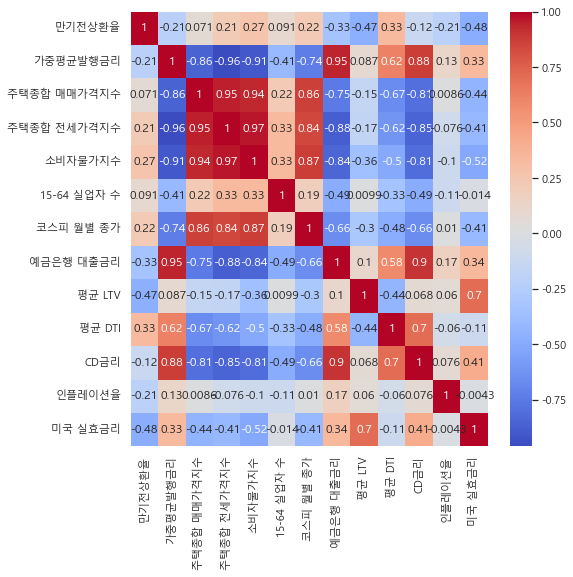

In [7]:
# 히트맵을 위한 라이브러리 호출
import matplotlib.pyplot as plt
import seaborn as sns

# 상관관계 확인
sns.set(rc={'figure.figsize':(8,8)}) ## 히트맵 크기 설정
plt.rc('font', family='Malgun Gothic') ## 한글 깨짐 설정
sns.heatmap(data_a.corr(), annot=True, cmap='coolwarm') ## 히트맵 그리기
plt.rcParams['axes.unicode_minus'] = False ## 마이너스 부호 깨지는 걸 방지함
plt.show()

    > 변수들의 상관관계가 높게 나옴  
    > 근데 경제 변수들은 다 영향을 줄 수 밖에 없음  
    > 그래서 금리, 부동산, 거시경제 요인으로 변수를 나눠서 사용할거임  

In [8]:
# 모든 컬럼 VIF 확인
from test_package import find_vif
find_vif(data_a)

      VIF Factor     features
0   31714.806054      소비자물가지수
1    4842.605006  15-64 실업자 수
2    4814.066900       평균 DTI
3    3992.642849    코스피 월별 종가
4    3919.618303       평균 LTV
5    2447.164077  주택종합 전세가격지수
6    1783.607609  주택종합 매매가격지수
7     843.060791     가중평균발행금리
8     651.679970    예금은행 대출금리
9      50.397849         CD금리
10     13.160977       만기전상환율
11      5.674646      미국 실효금리
12      1.486125       인플레이션율


    > 전체로 보면 변수들의 상관관계가 높음
    > VIF : 다중 회귀 모델에서 독립 변수간 상관 관계가 있는지 측정하는 척도

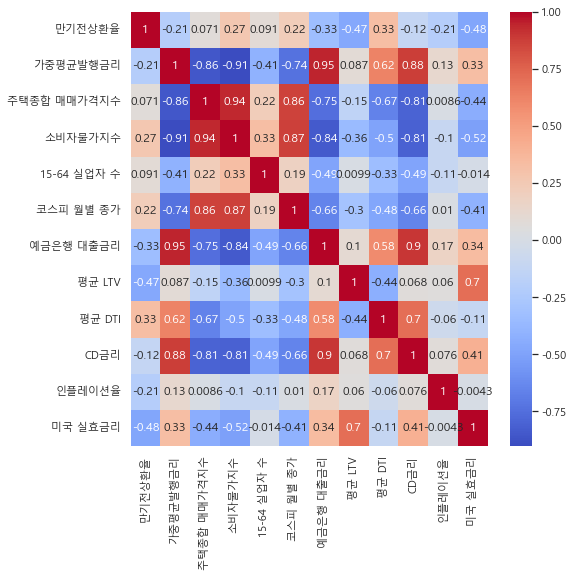

In [9]:
# 상관관계 확인 후 필요 없는 요인 제거
data_b = data_a.copy()
data_b.drop(columns=['주택종합 전세가격지수'], inplace=True)

# 상관관계 재확인
sns.set(rc={'figure.figsize':(8,8)}) # 히트맵 크기 설정
plt.rc('font', family='Malgun Gothic') # 한글 깨짐 설정
sns.heatmap(data_b.corr(), annot=True, cmap='coolwarm') # 히트맵 그리기
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨지는 걸 방지함
plt.show()

    > 상관성 높은 변수 삭제하고 VIF재확인

In [10]:
# VIF 재확인
find_vif(data_b)

      VIF Factor     features
0   28101.974160      소비자물가지수
1    4837.832254  15-64 실업자 수
2    4748.383149       평균 DTI
3    3990.394589    코스피 월별 종가
4    3797.582178       평균 LTV
5    1080.104819  주택종합 매매가격지수
6     650.082849    예금은행 대출금리
7     377.558056     가중평균발행금리
8      49.717188         CD금리
9      11.612551       만기전상환율
10      5.573446      미국 실효금리
11      1.483290       인플레이션율


### Scaling
    > - Standard : 데이터를 표준정규분포 모양으로 만듬 -> 데이터 특성을 반영 못 하니까 못 씀
    > - Robuster : 아웃라이어를 없애버림 -> 막판에 만기전상환율이 튀는 걸 살리는 게 맞는 것 같음 -> 못 씀
    > - Min-Max : 아웃라이어 살리고 데이터 분포 살림 (-> 남는 게 이거 뿐)

In [11]:
# Min - Max Scaler
from sklearn.preprocessing import MinMaxScaler

data_c = data_b.copy().reset_index()
scaler = MinMaxScaler()
mm_temp = data_c.drop(columns=['기준월','만기전상환율'])
colnames = data_c.columns.drop(['기준월','만기전상환율'])

mm_data = scaler.fit_transform(mm_temp)

mm_result = pd.DataFrame(mm_data, columns=colnames)

In [12]:
# Min-Max 스케일링 확인
mm_result.describe()

,가중평균발행금리,주택종합 매매가격지수,소비자물가지수,15-64 실업자 수,코스피 월별 종가,예금은행 대출금리,평균 LTV,평균 DTI,CD금리,인플레이션율,미국 실효금리
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,0.475174,0.391619,0.545529,0.442031,0.608737,0.471166,0.490067,0.619326,0.588164,0.483121,0.476425
std,0.342226,0.224773,0.265811,0.239491,0.191978,0.272720,0.275303,0.253078,0.240071,0.182259,0.329098
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.151139,0.245137,0.339965,0.272091,0.530060,0.244010,0.295559,0.429185,0.421530,0.350115,0.169347
50%,0.345682,0.389199,0.632525,0.401178,0.655505,0.424255,0.512553,0.674756,0.636004,0.478009,0.371111
75%,0.844064,0.521072,0.766320,0.596864,0.701062,0.714181,0.653614,0.832489,0.764200,0.594392,0.793112
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# Min-Max 스케일링 결측치 확인
mm_result.isna().sum()

가중평균발행금리       0
주택종합 매매가격지수    0
소비자물가지수        0
15-64 실업자 수    0
코스피 월별 종가      0
예금은행 대출금리      0
평균 LTV         0
평균 DTI         0
CD금리           0
인플레이션율         0
미국 실효금리        0
dtype: int64

### 피처, 타겟 설정

    > 크게 세가지로 변수 분리
    > 주요 요인 별로 나눈 이유 -> 각 상관관계가 너무 높아서

In [14]:
# 최적의 알파값을 찾기 전에 피처랑 타겟 설정
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

target = data_a['만기전상환율'] ### 타깃

feature_data = mm_result        ### ALL

## 변수 각각 분석
# feature_data_A = mm_result[['가중평균발행금리', '예금은행 대출금리', 'CD금리']]         ### 금리 요인(CD포함)
feature_data_A = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리']] ### 금리 요인(CD미포함)
feature_data_B = mm_result[['주택종합 매매가격지수', '평균 LTV', '평균 DTI']]           ### 부동산 요인
feature_data_C = mm_result[['15-64 실업자 수', '인플레이션율', '코스피 월별 종가']]     ### 거시경제 요인
##---------------------------------------------------------------------------------------------

# ## 변수 합쳐서 분석
# feature_data2_A = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리']]                                 ### 금리 요인(CD미포함)
# feature_data2_B = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리', '주택종합 매매가격지수', '평균 LTV', '평균 DTI']] ### 금리 요인 + 부동산 요인
# feature_data2_C = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리', '주택종합 매매가격지수', '평균 LTV', '평균 DTI'
#                             , '15-64 실업자 수', '인플레이션율', '코스피 월별 종가']]                                   ### 금리 요인 + 부동산 요인 + 거시경제 요인

In [15]:
# VIF after Min-Max Scaling
## 카테고리끼리 VIF 비교

from test_package import find_vif

datas = [feature_data
        , feature_data_A, feature_data_B, feature_data_C]
        # , feature_data2_A, feature_data2_B, feature_data2_C
num = range(1,len(datas)+1)

for num, data in zip(num, datas):
        # print("번호", num)
        print(f'번호 {num}')
        find_vif(data)
        print(' ')

번호 1
    VIF Factor     features
0   260.969745      소비자물가지수
1   188.758992  주택종합 매매가격지수
2   100.422746    예금은행 대출금리
3    89.892810         CD금리
4    58.134576    코스피 월별 종가
5    51.460361     가중평균발행금리
6    41.200982       평균 DTI
7    14.542231       평균 LTV
8    13.144297      미국 실효금리
9     8.885765       인플레이션율
10    7.595868  15-64 실업자 수
 
번호 2
   VIF Factor   features
0   28.404601  예금은행 대출금리
1   24.658323   가중평균발행금리
2    2.971325    미국 실효금리
 
번호 3
   VIF Factor     features
0    2.659064       평균 LTV
1    2.375083       평균 DTI
2    2.321795  주택종합 매매가격지수
 
번호 4
   VIF Factor     features
0    7.126936    코스피 월별 종가
1    5.074282       인플레이션율
2    4.078608  15-64 실업자 수
 


    > 스케일링 하니까 공선성이 개선된 것 같긴 함

### 최적의 알파값 & 요인 별 RMSE 스코어 계산

In [16]:
# 75% 수준의 데이터만 가지고 돌림
## Test SET 20%일 경우 -> 코로나 시국 데이터가 좀 더 반영됨
from test_package import alpha_master, find_best_alpha

datas = [feature_data
        , feature_data_A, feature_data_B, feature_data_C]
        # , feature_data2_A, feature_data2_B, feature_data2_C
types = ['ridge', 'lasso', 'elastic']
num = range(1,len(datas)+1)

for num, data in zip(num, datas):
    print(f'# 요인 : {data.columns.to_list()}')

    for i in range(0, len(types)):
        alpha_master(types[i], data[:161], target[:161])

### find_best_alpha + score_checker
### alpha_master('elastic', feature_data, target)

# 요인 : ['가중평균발행금리', '주택종합 매매가격지수', '소비자물가지수', '15-64 실업자 수', '코스피 월별 종가', '예금은행 대출금리', '평균 LTV', '평균 DTI', 'CD금리', '인플레이션율', '미국 실효금리']
Type : ridge | {'alpha': 1.0} | MSE : 0.28861237515349164 | RMSE: 0.5372265584960331
Alpha : 1.0
ridge Negative MSE score : [0.422 0.207 0.184 1.139 4.356]
ridge RMSE scores : [0.65  0.454 0.429 1.067 2.087]
ridge AVG RMSE : 0.937

Type : lasso | {'alpha': 0.01} | MSE : 0.21165140421128373 | RMSE: 0.4600558707497207
Alpha : 0.01
lasso Negative MSE score : [0.574 0.152 0.151 1.105 3.373]
lasso RMSE scores : [0.758 0.39  0.388 1.051 1.837]
lasso AVG RMSE : 0.885

Type : elastic | {'alpha': 0.01} | MSE : 0.14391019805265687 | RMSE: 0.379354976311972
Alpha : 0.01
elastic Negative MSE score : [0.347 0.188 0.177 1.135 3.559]
elastic RMSE scores : [0.589 0.434 0.42  1.065 1.886]
elastic AVG RMSE : 0.879

# 요인 : ['가중평균발행금리', '예금은행 대출금리', '미국 실효금리']
Type : ridge | {'alpha': 1.0} | MSE : 0.3237959149666553 | RMSE: 0.5690306801629024
Alpha : 1.0
ridge Negative MS

    > 어떤 경우엔 릿지가 낫고, 어떤 경우엔 랏소가 나아서 두 모형의 장점을 모은 엘라스틱넷을 사용하려고 함

### 예측

In [17]:
## 모델 : Lasso, Ridge, ElasticNet


## feature_data: 요인 전체
xd_train, xd_test, yd_train, yd_test = train_test_split(feature_data, target, test_size=0.25, random_state=25)
xd_model = ElasticNet(alpha=0.01, random_state=25)
xd_model.fit(xd_train, yd_train)
xd_pred = xd_model.predict(xd_test)
###------------------------------------------------------------------------------------------

## feature_data_A : 금리 요인
xa_train, xa_test, ya_train, ya_test = train_test_split(feature_data_A, target, test_size=0.25, random_state=25)
xa_model = ElasticNet(alpha=0.01, random_state=25)
xa_model.fit(xa_train, ya_train)
xa_pred = xa_model.predict(xa_test)

## feature_data_B : 부동산 요인
xb_train, xb_test, yb_train, yb_test = train_test_split(feature_data_B, target, test_size=0.25, random_state=25)
xb_model = ElasticNet(alpha=0.02, random_state=25)
xb_model.fit(xb_train, yb_train)
xb_pred = xb_model.predict(xb_test)

## feature_data_C : 거시경제 요인
xc_train, xc_test, yc_train, yc_test = train_test_split(feature_data_C, target, test_size=0.25, random_state=25)
xc_model = ElasticNet(alpha=0.01, random_state=25)
xc_model.fit(xc_train, yc_train)
xc_pred = xc_model.predict(xc_test)
###------------------------------------------------------------------------------------------

# ## feature_data2_A : 금리 요인(최적 : Lasso)
# xaa_train, xaa_test, yaa_train, yaa_test = train_test_split(feature_data2_A, target, test_size=0.25, random_state=25)
# xaa_model = ElasticNet(alpha=0.01, random_state=25)
# xaa_model.fit(xaa_train, yaa_train)
# xaa_pred = xaa_model.predict(xaa_test)

# ## feature_data2_B : 금리 + 부동산 요인(최적 : Lasso)
# xbb_train, xbb_test, ybb_train, ybb_test = train_test_split(feature_data2_B, target, test_size=0.25, random_state=25)
# xbb_model = ElasticNet(alpha=0.01, random_state=25)
# xbb_model.fit(xbb_train, ybb_train)
# xbb_pred = xbb_model.predict(xbb_test)

# ## feature_data2_C : 금리 + 부동산 + 거시경제 요인(최적 : Lasso)
# xcc_train, xcc_test, ycc_train, ycc_test = train_test_split(feature_data2_C, target, test_size=0.25, random_state=25)
# xcc_model = ElasticNet(alpha=0.01, random_state=25)
# xcc_model.fit(xcc_train, ycc_train)
# xcc_pred = xcc_model.predict(xcc_test)
# ###------------------------------------------------------------------------------------------

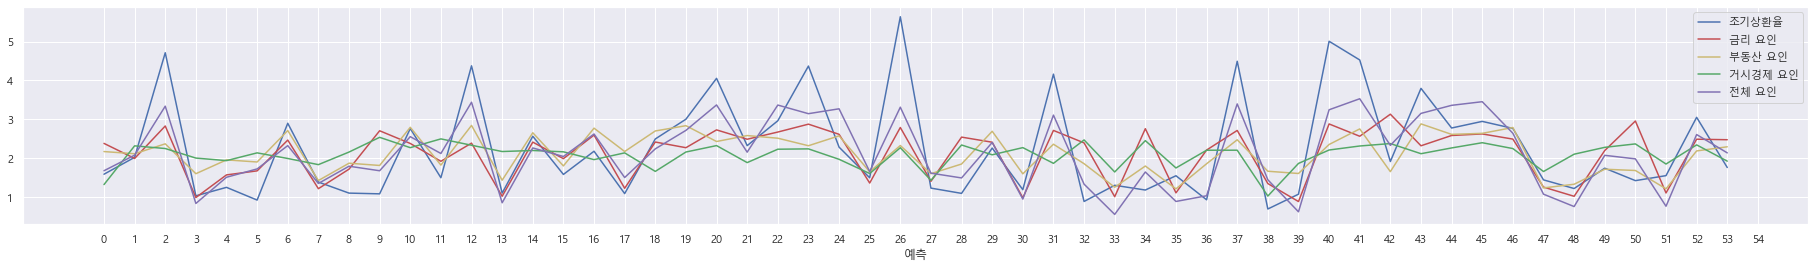

In [18]:
# 단일변수 한번에 시각화
fig, axs = plt.subplots(1,1, figsize=(32,4))
plt.xlabel("예측")
plt.xticks(range(55), range(55))
plt.plot(yd_test, label="조기상환율")
plt.plot(xa_pred, label="금리 요인", c='r')
plt.plot(xb_pred, label="부동산 요인", c='y')
plt.plot(xc_pred, label="거시경제 요인", c='g')
plt.plot(xd_pred, label="전체 요인", c='m')

plt.legend(loc='upper right')
plt.show()

# # 합친변수 한번에 시각화
# fig, axs = plt.subplots(1,1, figsize=(32,4))
# plt.xlabel("여러 변수 합친 예측")
# plt.xticks(range(55), range(55))
# plt.plot(yd_test, label="조기상환율")
# plt.plot(xaa_pred, label="금리 요인", c='r')
# plt.plot(xbb_pred, label="금리 + 부동산 요인", c='y')
# plt.plot(xcc_pred, label="금리 + 부동산 + 거시경제 요인", c='g')
# plt.plot(xd_pred, label="전체 요인", c='m')

# plt.legend(loc='upper right')
# plt.show()

    > 각각 요인으로 예측 한 것 보다 전체 요인이 예측률 좋음

In [19]:
from sklearn.metrics import mean_squared_error, accuracy_score

## 각각 요인으로 예측한 조기 상환율 RMSE 값
mse_a = mean_squared_error(ya_test, xa_pred)
rmse_a = mse_a ** 0.5
mse_b = mean_squared_error(yb_test, xb_pred)
rmse_b = mse_b ** 0.5
mse_c = mean_squared_error(yc_test, xc_pred)
rmse_c = mse_c ** 0.5
mse_all = mean_squared_error(yd_test, xd_pred)
rmse_all = mse_all ** 0.5

print('# 각각 요인')
print(f'금리 요인 RMSE : {rmse_a:.3f}')
print(f'부동산 요인 RMSE : {rmse_b:.3f}')
print(f'거시경제 요인 RMSE : {rmse_c:.3f}')
print(f'전체 요인 RMSE : {rmse_all:.3f}')
print(" ")

# ## 합한 요인으로 예측한 조기 상환율 RMSE 값
# mse_aa = mean_squared_error(yaa_test, xaa_pred)
# rmse_aa = mse_aa ** 0.5
# mse_bb = mean_squared_error(ybb_test, xbb_pred)
# rmse_bb = mse_bb ** 0.5
# mse_cc = mean_squared_error(ycc_test, xcc_pred)
# rmse_cc = mse_cc ** 0.5
# mse_all = mean_squared_error(yd_test, xd_pred)
# rmse_all = mse_all ** 0.5

# print('# 합한 요인')
# print(f'금리 요인 RMSE : {rmse_aa:.3f}')
# print(f'금리 + 부동산 요인 RMSE : {rmse_bb:.3f}')
# print(f'금리 + 부동산 + 거시경제 요인 RMSE : {rmse_cc:.3f}')
# print(f'전체 요인 RMSE : {rmse_all:.3f}')

# 각각 요인
금리 요인 RMSE : 1.020
부동산 요인 RMSE : 1.015
거시경제 요인 RMSE : 1.231
전체 요인 RMSE : 0.701
 


    > RMSE를 봐도 각각 요인보다 전체 요인이 더 낮아진 것을 볼 수 있음

In [20]:
# elasticnet 잘 됐는지 스코어 확인

## 각각 요인 예측
print(f'금리 요인 훈련셋 점수 : {xa_model.score(xa_train, ya_train):.3f}')
print(f'금리 요인 테스트 점수 : {xa_model.score(xa_test, ya_test):.3f}\n')

print(f'부동산 요인 훈련셋 점수 : {xb_model.score(xb_train, yb_train):.3f}')
print(f'부동산 요인 테스트 점수 : {xb_model.score(xb_test, yb_test):.3f}\n')

print(f'거시경제 요인 훈련셋 점수 : {xc_model.score(xc_train, yc_train):.3f}')
print(f'거시경제 요인 테스트 점수 : {xc_model.score(xc_test, yc_test):.3f}\n')

print(f'전체 요인 훈련셋 점수 : {xd_model.score(xd_train, yd_train):.3f}')
print(f'전체 요인 테스트 점수 : {xd_model.score(xd_test, yd_test):.3f}\n')

# ## 합한 요인 예측
# print(f'금리 요인 훈련셋 점수 : {xaa_model.score(xaa_train, yaa_train):.3f}')
# print(f'금리 요인 테스트 점수 : {xaa_model.score(xaa_test, yaa_test):.3f}')

# print(f'금리+부동산 요인 훈련셋 점수 : {xbb_model.score(xbb_train, ybb_train):.3f}')
# print(f'금리+부동산 요인 테스트 점수 : {xbb_model.score(xbb_test, ybb_test):.3f}')

# print(f'금리+부동산+거시경제 요인 훈련셋 점수 : {xcc_model.score(xcc_train, ycc_train):.3f}')
# print(f'금리+부동산 요인 테스트 점수 : {xcc_model.score(xcc_test, ycc_test):.3f}')

# print(f'전체 요인 훈련셋 점수 : {xd_model.score(xd_train, yd_train):.3f}')
# print(f'전체 요인 테스트 점수 : {xd_model.score(xd_test, yd_test):.3f}\n')

금리 요인 훈련셋 점수 : 0.306
금리 요인 테스트 점수 : 0.352

부동산 요인 훈련셋 점수 : 0.206
부동산 요인 테스트 점수 : 0.358

거시경제 요인 훈련셋 점수 : 0.093
거시경제 요인 테스트 점수 : 0.055

전체 요인 훈련셋 점수 : 0.535
전체 요인 테스트 점수 : 0.694



    > 요인들의 알파를 구하고 RMSE를 봤더니 전체 요인 RMSE가 가장 낮았음
    > => 전체 요인의 예측 정확도가 높다는 뜻
    > 어떤 요인이 예측에 큰 비중을 갖고있는지 알아보려 함

    > ----------------------------------------------------------------------

    > 규제를 높여서(알파값 의도적 높임)
    > 어떤 요인들이 그 집단에서 가장 큰 영향력을 주는지 보려고 함

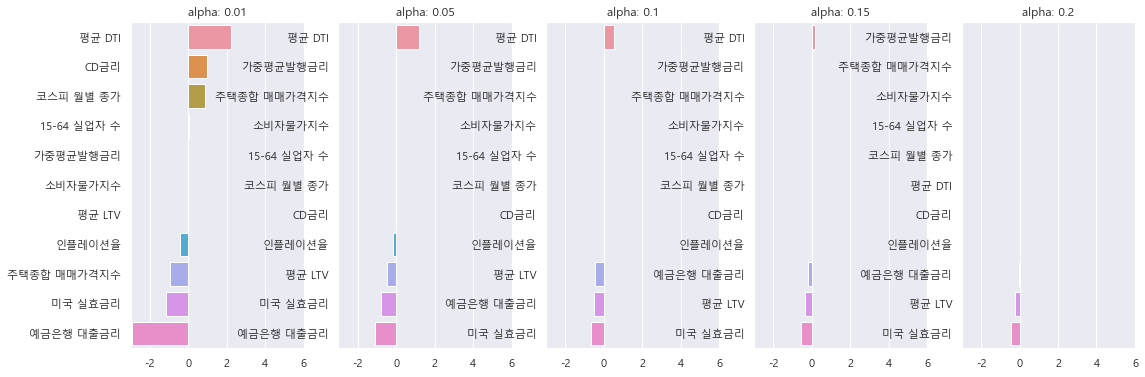

             alpha: 0.01  alpha: 0.05  alpha: 0.1  alpha: 0.15  alpha: 0.2
평균 DTI          2.204101     1.183250    0.513585     0.181450    0.000000
CD금리            0.970716     0.000000   -0.000000    -0.000000   -0.000000
코스피 월별 종가       0.872597     0.000000    0.000000     0.000000    0.000000
15-64 실업자 수     0.033942     0.000000    0.000000     0.000000    0.000000
가중평균발행금리        0.000000    -0.000000   -0.000000    -0.000000   -0.000000
소비자물가지수        -0.000000     0.000000    0.000000     0.000000    0.000000
평균 LTV         -0.000000    -0.473250   -0.440078    -0.335746   -0.227537
인플레이션율         -0.422307    -0.167800   -0.000000    -0.000000   -0.000000
주택종합 매매가격지수    -0.975404    -0.000000   -0.000000    -0.000000    0.000000
미국 실효금리        -1.149811    -0.788343   -0.674141    -0.550574   -0.432978
예금은행 대출금리      -2.944008    -1.115623   -0.514459    -0.202010   -0.013169


In [21]:
# 전체 요인 규제

### check_coeff(type, data, target, alpha)
### type = 'ridge', 'lasso', 'elastic'

from test_package import check_coeff

alphas = [0.01, 0.05, 0.1, 0.15, 0.2]
check_coeff('elastic', feature_data, target, alphas)

    > 전체 요인에 규제를 강화했을 때 평균 DTI, 미국 실효금리, 평균 LTV, 예금은행 대출금리가 영향력이 큰 것을 알 수 있음

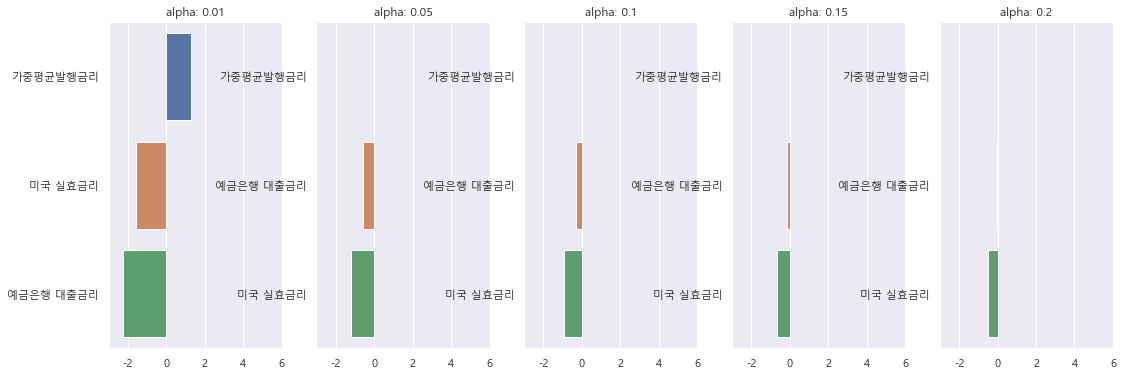

           alpha: 0.01  alpha: 0.05  alpha: 0.1  alpha: 0.15  alpha: 0.2
가중평균발행금리      1.280834     0.000000   -0.000000    -0.000000   -0.000000
미국 실효금리      -1.583582    -1.225996   -0.919503    -0.686008   -0.502674
예금은행 대출금리    -2.229063    -0.552078   -0.315256    -0.142817   -0.011056


In [22]:
# 금리 요인 규제
alphas = [0.01, 0.05, 0.1, 0.15, 0.2]
check_coeff('elastic', feature_data_A, target, alphas)

    > 금리 요인에 규제를 강화했을 때 미국 실효금리, 예금은행 대출금리가 영향력이 큰 것을 알 수 있음

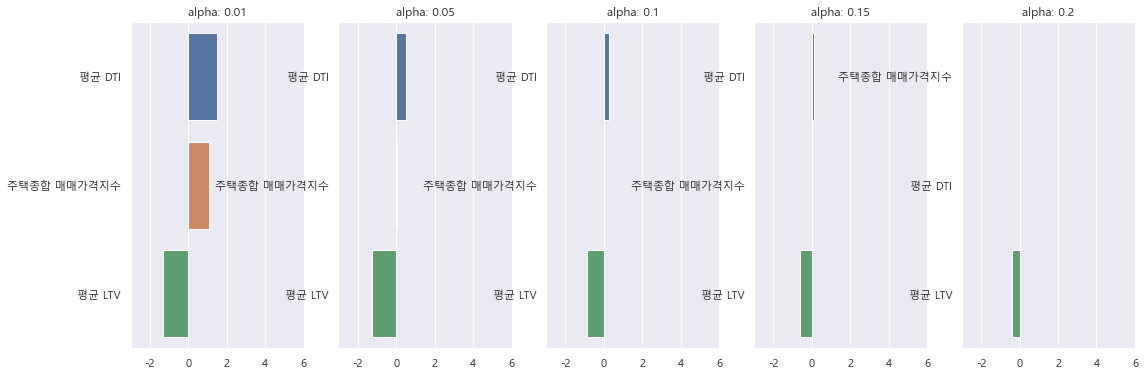

             alpha: 0.01  alpha: 0.05  alpha: 0.1  alpha: 0.15  alpha: 0.2
평균 DTI          1.487378     0.517204    0.272063     0.103193    0.000000
주택종합 매매가격지수     1.070551     0.044402    0.000000     0.000000    0.000000
평균 LTV         -1.335536    -1.258574   -0.870820    -0.593851   -0.384502


In [23]:
# 부동산 요인 규제
alphas = [0.01, 0.05, 0.1, 0.15, 0.2]
check_coeff('elastic', feature_data_B, target, alphas)

    > 부동산 요인에 규제를 강화했을 때 평균 DTI, 평균 LTV가 영향력이 큰 것을 알 수 있음

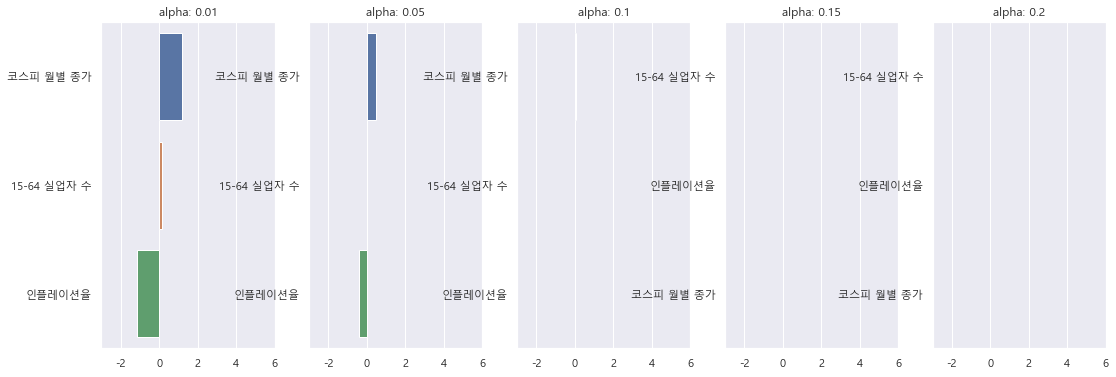

             alpha: 0.01  alpha: 0.05  alpha: 0.1  alpha: 0.15  alpha: 0.2
코스피 월별 종가       1.179016     0.485425    0.055305          0.0         0.0
15-64 실업자 수     0.123590     0.000000    0.000000          0.0         0.0
인플레이션율         -1.141797    -0.409585   -0.000000         -0.0        -0.0


In [24]:
# 거시경제 요인 규제
alphas = [0.01, 0.05, 0.1, 0.15, 0.2]
check_coeff('elastic', feature_data_C, target, alphas)

    > 거시경제 요인에 규제를 강화했을 때 영향력이 큰 것이 없는 것을 알 수 있음

### 영향력 큰 요인들과 아닌 요인들로 나눠서 예측해보려 함


In [25]:
from test_package import score_checker

# 변수 분류
feature_data_best = feature_data[['평균 LTV', '평균 DTI', '예금은행 대출금리', '미국 실효금리']]    ## 영향력 큰 요인
feature_data_others = feature_data[['가중평균발행금리', '주택종합 매매가격지수', '소비자물가지수'    ## 그 외 요인
                                    , '15-64 실업자 수', '코스피 월별 종가', '인플레이션율']]


find_best_alpha('elastic', feature_data_best[:161], target[:161])   ## 영향력 큰 요인의 알파값 & RMSE 스코어
score_checker('elastic', feature_data_best[:161], target[:161], 0.01)

find_best_alpha('elastic', feature_data_others[:161], target[:161]) ## 그 외 요인의 알파값 & RMSE 스코어
score_checker('elastic', feature_data_others[:161], target[:161], 0.01)

Type : elastic | {'alpha': 0.02} | MSE : 0.28231428773153 | RMSE: 0.5313325585088213
Alpha : 0.01
elastic Negative MSE score : [0.463 0.294 0.166 1.167 2.641]
elastic RMSE scores : [0.68  0.542 0.407 1.08  1.625]
elastic AVG RMSE : 0.867

Type : elastic | {'alpha': 0.01} | MSE : 0.6449465069873049 | RMSE: 0.8030856162248861
Alpha : 0.01
elastic Negative MSE score : [0.489 0.418 0.155 1.53  3.566]
elastic RMSE scores : [0.7   0.647 0.393 1.237 1.888]
elastic AVG RMSE : 0.973



In [26]:
# 예측
## 영향력 큰 요인
xe_train, xe_test, ye_train, ye_test = train_test_split(feature_data_best, target, test_size=0.25, random_state=25)
xe_model = ElasticNet(alpha=0.01, random_state=25)
xe_model.fit(xe_train, ye_train)
xe_pred = xe_model.predict(xe_test)

## 그 외 요인
xf_train, xf_test, yf_train, yf_test = train_test_split(feature_data_others, target, test_size=0.25, random_state=25)
xf_model = ElasticNet(alpha=0.01, random_state=25)
xf_model.fit(xf_train, yf_train)
xf_pred = xf_model.predict(xf_test)

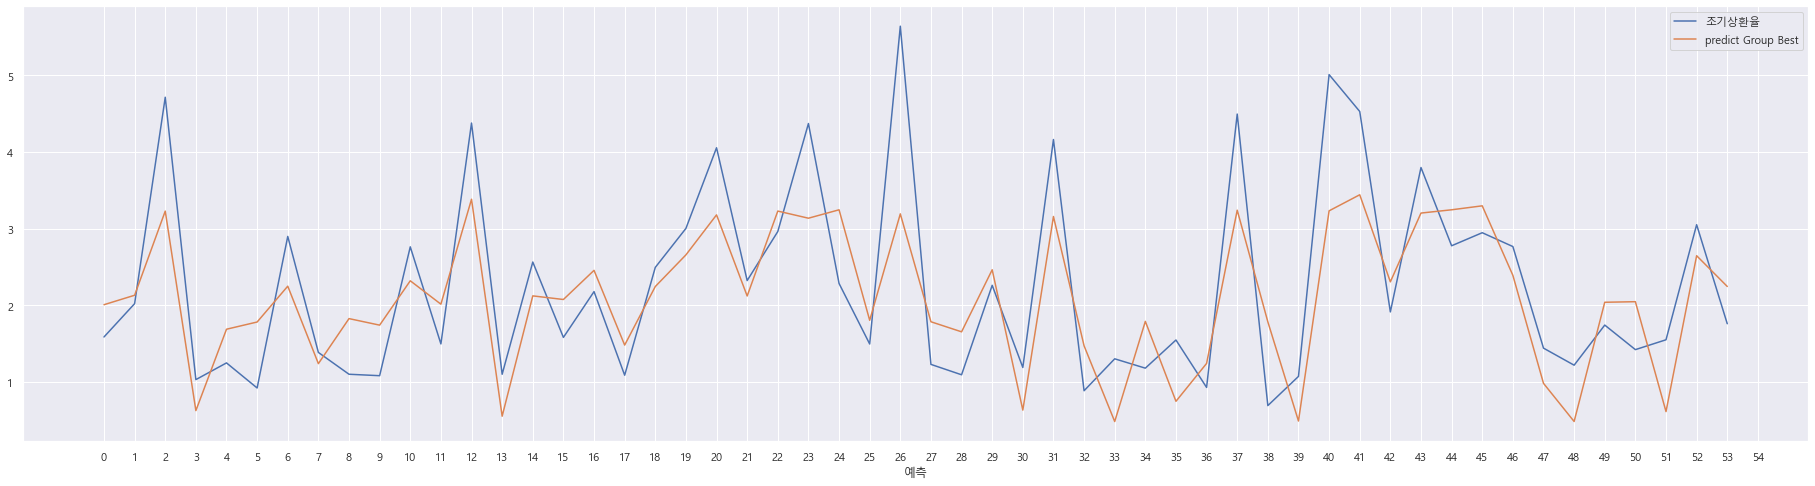

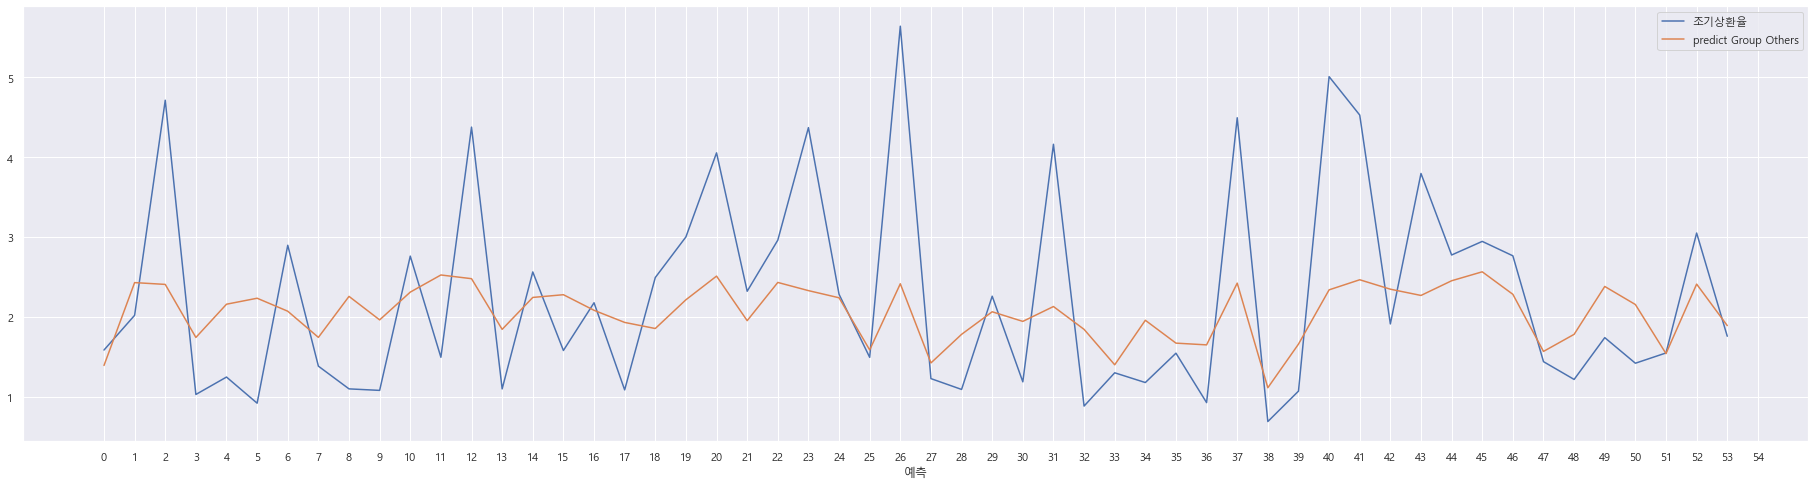

In [27]:
# 영향이 큰 변수 시각화
fig, axs = plt.subplots(1,1, figsize=(32,8))
plt.xlabel("예측")
plt.xticks(range(55), range(55))
plt.plot(ye_test, label="조기상환율")
plt.plot(xe_pred, label="predict Group Best")
plt.legend(loc='upper right')
plt.show()

# 그 외 요인 시각화
fig, axs = plt.subplots(1,1, figsize=(32,8))
plt.xlabel("예측")
plt.xticks(range(55), range(55))
plt.plot(yf_test, label="조기상환율")
plt.plot(xf_pred, label="predict Group Others")
plt.legend(loc='upper right')
plt.show()

In [28]:
# 최종 검증
mse_a = mean_squared_error(ya_test, xa_pred)
rmse_a = mse_a ** 0.5

mse_b = mean_squared_error(yb_test, xb_pred)
rmse_b = mse_b ** 0.5

mse_c = mean_squared_error(yc_test, xc_pred)
rmse_c = mse_c ** 0.5

mse_all = mean_squared_error(yd_test, xd_pred)
rmse_all = mse_all ** 0.5

mse_best = mean_squared_error(ye_test, xe_pred)
rmse_best = mse_best ** 0.5

mse_others = mean_squared_error(yf_test, xf_pred)
rmse_others = mse_others ** 0.5


print(f'전체 요인 중 가장 영향력 높은 RMSE : {rmse_best:.3f}')
print(f'영향력 높은 요인을 제외한 나머지 RMSE : {rmse_others:.3f}')

print(f'금리 요인 RMSE : {rmse_a:.3f}')
print(f'부동산 요인 RMSE : {rmse_b:.3f}')
print(f'거시경제 요인 RMSE : {rmse_c:.3f}')
print(f'전체 요인 RMSE : {rmse_all:.3f}')


전체 요인 중 가장 영향력 높은 RMSE : 0.769
영향력 높은 요인을 제외한 나머지 RMSE : 1.096
금리 요인 RMSE : 1.020
부동산 요인 RMSE : 1.015
거시경제 요인 RMSE : 1.231
전체 요인 RMSE : 0.701


    > 영향력 높은 요인(4개)의 RMES값이 전체 요인(11개)의 RMSE값과 비슷하게 나옴
    > => 이걸로 4개의 요인이 예측에 큰 영향을 주는것을 알 수 있음

In [29]:
# R2 확인 - OLS 분석
import statsmodels.api as sm

lm = sm.OLS(list(target), feature_data_best)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.858
Model:                            OLS   Adj. R-squared (uncentered):              0.856
Method:                 Least Squares   F-statistic:                              318.3
Date:                Wed, 07 Sep 2022   Prob (F-statistic):                    6.55e-88
Time:                        21:13:20   Log-Likelihood:                         -289.54
No. Observations:                 214   AIC:                                      587.1
Df Residuals:                     210   BIC:                                      600.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
평균 LTV         1.8126      0.288      6.301      0.000       1.246       2.380
평균 DTI         5.6120      0.237     23.713      0.000       5.145       6.079
예금은행 대출금리     -3.8809      0.334    -11.634      0.000      -4.539      -3.223
미국 실효금리       -1.0276      0.298     -3.454      0.001      -1.614      -0.441
==============================================================================
Omnibus:                       57.658   Durbin-Watson:                   0.482
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              412.438
Skew:                           0.795   Prob(JB):                     2.76e-90
Kurtosis:                       9.613   Cond. No.                         7.05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

    > ############# 맞는지 확인 ##############

    > R-스쿼어드는 모델의 분산 설명력이라고 볼 수 있으며 모델이 얼마나 데이터를 잘 설명했는지를 의미하는 값임
    > R제곱이 1이라면 오차제곱이 0이므로 training error가 0인 것을 의미함
    > 따라서 0.853의 수치는 괜찮은 것으로 보임

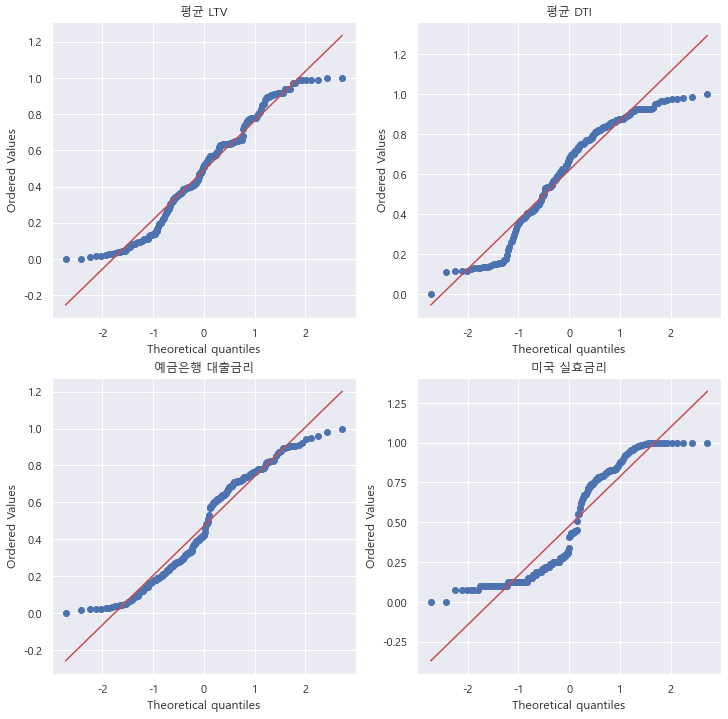

In [30]:
# 데이터 정규성 확인
from scipy import stats

fig, axes = plt.subplots(2, 2)
fig.set_size_inches((12,12))
plt.rc('font', family='Malgun Gothic') ## 한글 깨짐 설정

stats.probplot(feature_data_best["평균 LTV"], dist=stats.norm, plot=axes[0,0])
axes[0,0].title.set_text("평균 LTV")
stats.probplot(feature_data_best["평균 DTI"], dist=stats.norm, plot=axes[0,1])
axes[0,1].title.set_text("평균 DTI")
stats.probplot(feature_data_best["예금은행 대출금리"], dist=stats.norm, plot=axes[1,0])
axes[1,0].title.set_text("예금은행 대출금리")
stats.probplot(feature_data_best["미국 실효금리"], dist=stats.norm, plot=axes[1,1])
axes[1,1].title.set_text("미국 실효금리")

### 나아가기

In [70]:
# best feature -> 다중회귀 해보기
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# 다중회귀
pipe_test = Pipeline([('poly', PolynomialFeatures()), ('Linear', LinearRegression())])


x_best_train, x_best_test, y_best_train, y_best_test = train_test_split(feature_data_best, target, test_size=0.25, random_state=25)


params = {
        'poly__degree': [1,2,3,4,5,6,7], 
        'poly__include_bias': [False,True]
}


asd = GridSearchCV(pipe_test, params, cv=10, scoring='r2')

asd.fit(x_best_train, y_best_train)

print(f"Best: {asd.best_score_} using {asd.best_params_}")

### 가장 좋은 파라미터를 추출함
### grid에 파이프라인 넣어서 제일 좋은 파라미터값을 set_params에 보내줌
##########################################################################################
### gridCV에서 가장 좋은 파라미터 변수를 가져와서 파이프라인에 활용(gridCV안씀)

# print(asd.best_params_['poly__degree'], asd.best_params_['poly__include_bias'])

pipe_test.set_params(poly__degree=4, poly__include_bias=asd.best_params_['poly__include_bias'])

pipe_test.fit(x_best_train, y_best_train)

pipe_preds = pipe_test.predict(x_best_test)



mse_best_a = mean_squared_error(y_best_test, pipe_preds)
rmse_best_a = np.sqrt(mse_best_a)


print(f'MSE : {mse_best_a} | RMSE : {rmse_best_a}')
print(f'R-Square : {r2_score(y_best_test, pipe_preds)}')

Best: 0.6425986675330401 using {'poly__degree': 2, 'poly__include_bias': True}
MSE : 0.33625137635891805 | RMSE : 0.5798718620168752
R-Square : 0.790537264604438


In [ ]:
# 시각화
## 1. 예측값 & 단순선형회귀 & 다중선형회귀 예측값 비교

plt.figure(figsize=(16,8))
plt.plot(reg.predict(x_best_test), label="Predict Linear")
plt.plot(pipe_preds, label="Predict PipeLine")
plt.plot(y_best_test.values.reshape(-1,1), label="REAL") # Target Test Set
plt.legend(loc='best')
plt.show()

    > 이 결과는 우리가 릿지나 라쏘 엘라스틱을 써야한다는 정당성에 대한 확보가 될 것 같기도 하네...
    > 단순 선형회귀와 비교했을 때 파이프라인 넣고 다항식으로 만들면 R^2 값이 참 좋아지더라를 보여주면 끝날듯..?

In [50]:
# 그냥 다중선형회귀
reg = LinearRegression()
x_best_train2, x_best_test2, y_best_train2, y_best_test2 = train_test_split(feature_data_best, target, test_size=0.25, random_state=25)
reg.fit(x_best_train2, y_best_train2)
reg_preds = reg.predict(x_best_test2)

mse_best_b = mean_squared_error(y_best_test, reg_preds)
rmse_best_b = np.sqrt(mse_best_b)

print(f'MSE : {mse_best_b} | RMSE : {rmse_best_b}')
print(f'R-Square : {r2_score(y_best_test, reg_preds)}')

MSE : 0.5592001461227993 | RMSE : 0.7477968615358046
R-Square : 0.6516546831455876


    > 다중선형회귀(파이프라인 구축)보다 다중회귀의 r스퀘어 값이 높음

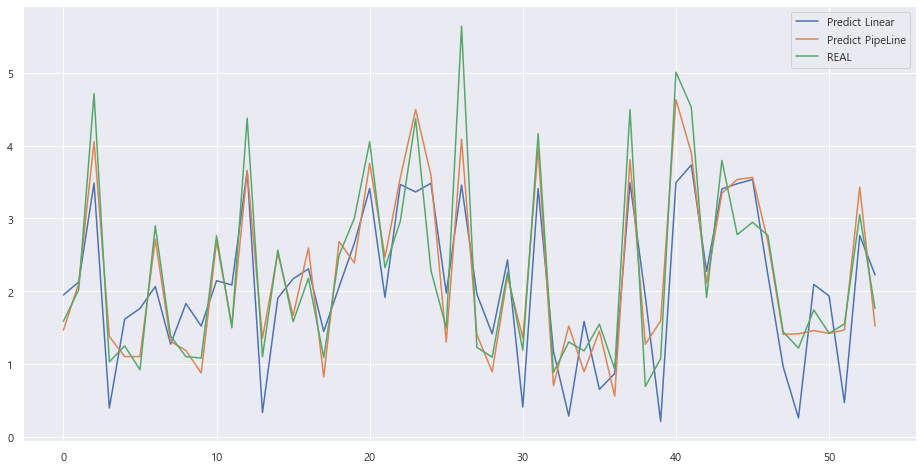

In [65]:
# 시각화
## 1. 예측값 & 단순선형회귀 & 다중선형회귀 예측값 비교

plt.figure(figsize=(16,8))
plt.plot(reg.predict(x_best_test), label="Predict Linear")
plt.plot(pipe_preds, label="Predict PipeLine")
plt.plot(y_best_test.values.reshape(-1,1), label="REAL") # Target Test Set
plt.legend(loc='best')
plt.show()

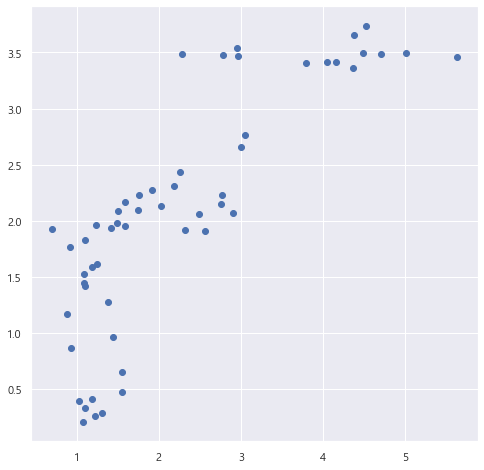

In [34]:
# Scatter with rinear_pred, target
## 단순선형회귀

plt.scatter(y_best_test, reg.predict(x_best_test))
plt.show()

In [35]:
reg.score(x_best_train, y_best_train)

0.5108615318616956

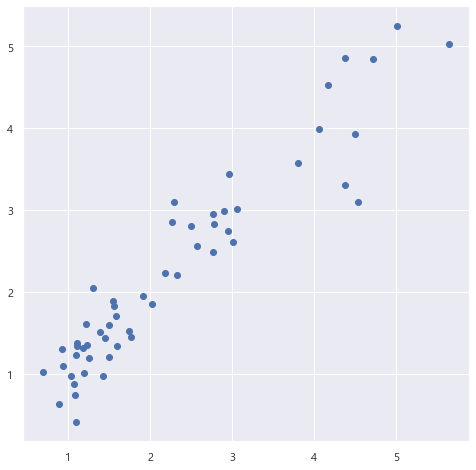

In [36]:
# scatter with pipe regression
## 다중회귀(파이프라인 구축)
plt.scatter(y_best_test, pipe_preds)
#lt.plot(y_best_test, pipe_preds)
plt.show()

In [37]:
pipe_test.score(x_best_train, y_best_train)

0.8365358169457224

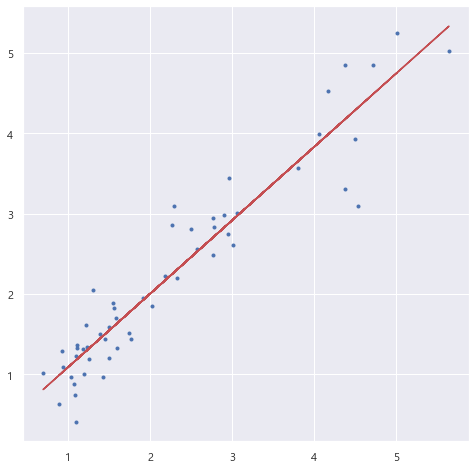

In [38]:
# 3. 파이프라인으로 N차 함수 만든 선형 그래프와 target plot 산점도
from scipy import stats, polyval

slope, intercept, r_value, p_value, stderr = stats.linregress(y_best_test, pipe_preds)
ry = polyval([slope, intercept], y_best_test)
plt.figure(figsize=(8,8))
plt.plot(y_best_test, pipe_preds, 'b.')
plt.plot(y_best_test, ry, 'r-')
plt.show()

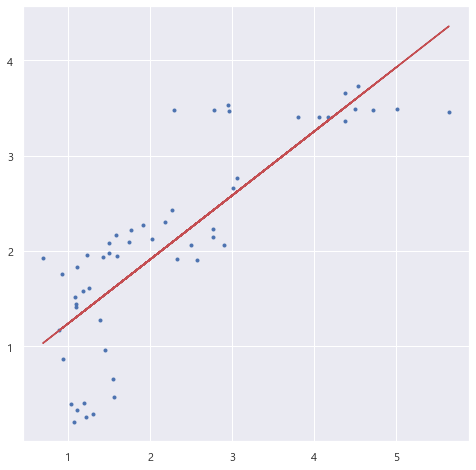

In [39]:
# 2. 단순선형회귀 한 거 가지고 직선으로 만든 선형 그래프과 target plot 산점도
slope, intercept, r_value, p_value, stderr = stats.linregress(y_best_test, reg_preds)
ry = polyval([slope, intercept], y_best_test)
plt.plot(y_best_test, reg_preds, 'b.')
plt.plot(y_best_test, ry, 'r-')
plt.show()

    > 단순보다 다중의 분포도가 고름